# Analyse arbitrage data we have

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

In [307]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

## Install stuff

In [2]:
!pip install pandas

You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
!pip install matplotlib

You should consider upgrading via the 'pip install --upgrade pip' command.


In [4]:
!pip install sqlalchemy

You should consider upgrading via the 'pip install --upgrade pip' command.


In [5]:
!pip install boto3

You should consider upgrading via the 'pip install --upgrade pip' command.


In [6]:
import sys
import os
import matplotlib
import pandas as pd
import matplotlib.pyplot as plt
import boto3

In [7]:
matplotlib.style.use('seaborn')

### Connect to AWS

Set your AWS profile name, or create session using your AWS keys

In [8]:
# aws_access_key = os.environ["GIW_AWS_ACCESS_KEY"]
# aws_access_secret = os.environ["GIW_AWS_ACCESS_SECRET"]
print()

In [9]:
# Set your AWS profile name, or create session using your AWS keys
boto3.setup_default_session(profile_name="goodit")

## Load data

In [10]:
table = boto3.resource("dynamodb").Table("patron-arbitrage")

In [11]:
response = table.scan()
data = response['Items']

In [12]:
len(data)

4010

In [14]:
df = pd.DataFrame(data)

In [15]:
df.head()

,roi,profit,market_path,market,coin_path,timems
0,0.0004259987362807971,0.0866664691354698,ANT/BUSD -> ANT/USDT -> BUSD/USDT,ANT/BUSD,BUSD -> ANT -> USDT -> BUSD,1620771914072
1,0.0003573882892536906,0.00094707896652228,AUCTION/BUSD -> BTC/BUSD -> AUCTION/BTC,AUCTION/BUSD,AUCTION -> BUSD -> BTC -> AUCTION,1620702298231
2,0.001756636192973171,1.416366979213303,EPS/BTC -> BTC/USDT -> EPS/USDT,EPS/BTC,EPS -> BTC -> USDT -> EPS,1620561473483
3,0.002334603798706425,1.7051946145751729,HOT/BUSD -> BNB/BUSD -> HOT/BNB,HOT/BUSD,HOT -> BUSD -> BNB -> HOT,1620644621758
4,0.009234737201892718,24.12021009762359,HOT/BUSD -> BUSD/TRY -> HOT/TRY,HOT/BUSD,HOT -> BUSD -> TRY -> HOT,1620644622511


In [16]:
starttime, endtime = min(df.timems), max(df.timems)

In [17]:
starttime = pd.to_datetime(int(starttime), unit="ms")
endtime = pd.to_datetime(int(endtime), unit="ms")

In [18]:
df["end_market"] = df["market_path"].apply(lambda s: s.split(" -> ")[2])

In [19]:
df["coin"] = df.coin_path.apply(lambda v: v.split(" -> ")[0])

In [20]:
df["coin_2"] = df.coin_path.apply(lambda v: v.split(" -> ")[1])

In [21]:
df["coin_3"] = df.coin_path.apply(lambda v: v.split(" -> ")[2])

In [22]:
df["profit"] = df.profit.apply(float)
df["roi"] = df.roi.apply(float)

In [23]:
df

,roi,profit,market_path,market,coin_path,timems,end_market,coin,coin_2,coin_3
0,0.000426,0.086666,ANT/BUSD -> ANT/USDT -> BUSD/USDT,ANT/BUSD,BUSD -> ANT -> USDT -> BUSD,1620771914072,BUSD/USDT,BUSD,ANT,USDT
1,0.000357,0.000947,AUCTION/BUSD -> BTC/BUSD -> AUCTION/BTC,AUCTION/BUSD,AUCTION -> BUSD -> BTC -> AUCTION,1620702298231,AUCTION/BTC,AUCTION,BUSD,BTC
2,0.001757,1.416367,EPS/BTC -> BTC/USDT -> EPS/USDT,EPS/BTC,EPS -> BTC -> USDT -> EPS,1620561473483,EPS/USDT,EPS,BTC,USDT
3,0.002335,1.705195,HOT/BUSD -> BNB/BUSD -> HOT/BNB,HOT/BUSD,HOT -> BUSD -> BNB -> HOT,1620644621758,HOT/BNB,HOT,BUSD,BNB
4,0.009235,24.120210,HOT/BUSD -> BUSD/TRY -> HOT/TRY,HOT/BUSD,HOT -> BUSD -> TRY -> HOT,1620644622511,HOT/TRY,HOT,BUSD,TRY
...,...,...,...,...,...,...,...,...,...,...
4005,0.005155,0.101908,BUSD/TRY -> HOT/TRY -> HOT/BUSD,BUSD/TRY,BUSD -> TRY -> HOT -> BUSD,1620644624650,HOT/BUSD,BUSD,TRY,HOT
4006,0.004173,3.028284,BUSD/TRY -> ETH/TRY -> ETH/BUSD,BUSD/TRY,BUSD -> TRY -> ETH -> BUSD,1620677129160,ETH/BUSD,BUSD,TRY,ETH
4007,0.001085,0.554424,BUSD/TRY -> ONT/TRY -> ONT/BUSD,BUSD/TRY,BUSD -> TRY -> ONT -> BUSD,1620677376493,ONT/BUSD,BUSD,TRY,ONT
4008,0.001389,0.633680,BUSD/TRY -> ONT/TRY -> ONT/BUSD,BUSD/TRY,BUSD -> TRY -> ONT -> BUSD,1620677442408,ONT/BUSD,BUSD,TRY,ONT


## Arbitrage windows length

In [299]:
filter_all_3_coins_in(df, ["BTC", "ETH", "USDT", "BUSD", "USDC", "EUR"])

,roi,profit,market_path,market,coin_path,timems,end_market,coin,coin_2,coin_3,price_usd,profit_usd
60,0.018553,0.036806,ETH/USDT -> EUR/USDT -> ETH/EUR,ETH/USDT,ETH -> USDT -> EUR -> ETH,1620677078304,ETH/EUR,ETH,USDT,EUR,3563.9500,131.174242
61,0.002335,0.005612,ETH/USDT -> EUR/USDT -> ETH/EUR,ETH/USDT,ETH -> USDT -> EUR -> ETH,1620677092755,ETH/EUR,ETH,USDT,EUR,3563.9500,20.001865
368,0.019440,11.064170,EUR/BUSD -> ETH/EUR -> ETH/BUSD,EUR/BUSD,BUSD -> EUR -> ETH -> BUSD,1620677078460,ETH/BUSD,BUSD,EUR,ETH,1.0000,11.064170
369,0.000897,0.335476,EUR/BUSD -> ETH/EUR -> ETH/BUSD,EUR/BUSD,BUSD -> EUR -> ETH -> BUSD,1620677092905,ETH/BUSD,BUSD,EUR,ETH,1.0000,0.335476
403,0.018553,111.150015,ETH/EUR -> ETH/USDT -> EUR/USDT,ETH/EUR,EUR -> ETH -> USDT -> EUR,1620677078494,EUR/USDT,EUR,ETH,USDT,1.2098,134.469288
405,0.000897,0.274921,ETH/EUR -> ETH/BUSD -> EUR/BUSD,ETH/EUR,EUR -> ETH -> BUSD -> EUR,1620677092918,EUR/BUSD,EUR,ETH,BUSD,1.2098,0.332599
1033,0.020451,0.000013,BTC/EUR -> ETH/EUR -> ETH/BTC,BTC/EUR,BTC -> EUR -> ETH -> BTC,1620677078345,ETH/BTC,BTC,EUR,ETH,58900.0000,0.795025
1034,0.003149,0.000033,BTC/EUR -> ETH/EUR -> ETH/BTC,BTC/EUR,BTC -> EUR -> ETH -> BTC,1620677092785,ETH/BTC,BTC,EUR,ETH,58900.0000,1.949637
1736,0.018553,135.286351,EUR/USDT -> ETH/EUR -> ETH/USDT,EUR/USDT,USDT -> EUR -> ETH -> USDT,1620677078379,ETH/USDT,USDT,EUR,ETH,1.0000,135.286351
1737,0.002335,20.953213,EUR/USDT -> ETH/EUR -> ETH/USDT,EUR/USDT,USDT -> EUR -> ETH -> USDT,1620677092850,ETH/USDT,USDT,EUR,ETH,1.0000,20.953213


In [316]:
arbitrage_ttls = dict()
df_counts = df.groupby(["coin", "roi"]).count().reset_index()
# df_counts = filter_all_3_coins_in(df, set_of_top_profit_coins).groupby(["coin", "roi"]).count().reset_index()
# df_counts = filter_all_3_coins_in(df, ["BTC", "ETH", "USDT", "BUSD", "USDC", "EUR"]).groupby(["coin", "roi"]).count().reset_index()
total_grouped_arbitrage_counts = len(df_counts)

short_ttl_count = len(df_counts[df_counts.profit == 1])
arbitrage_ttls[0] = short_ttl_count
print(f"TTL < 100 ms: {short_ttl_count} ({round(100*short_ttl_count/total_grouped_arbitrage_counts, 2)}%)")

TTL < 100 ms: 2487 (85.11%)


In [317]:
for i in range(1, 25):
    long_ttl_count = len(df_counts[df_counts.profit > i])
    arbitrage_ttls[100*i] = long_ttl_count
    print(f"TTL > {i}00 ms: {long_ttl_count} ({round(100*long_ttl_count/total_grouped_arbitrage_counts, 2)}%)")

TTL > 100 ms: 435 (14.89%)
TTL > 200 ms: 185 (6.33%)
TTL > 300 ms: 119 (4.07%)
TTL > 400 ms: 73 (2.5%)
TTL > 500 ms: 45 (1.54%)
TTL > 600 ms: 39 (1.33%)
TTL > 700 ms: 39 (1.33%)
TTL > 800 ms: 25 (0.86%)
TTL > 900 ms: 25 (0.86%)
TTL > 1000 ms: 22 (0.75%)
TTL > 1100 ms: 22 (0.75%)
TTL > 1200 ms: 13 (0.44%)
TTL > 1300 ms: 11 (0.38%)
TTL > 1400 ms: 6 (0.21%)
TTL > 1500 ms: 6 (0.21%)
TTL > 1600 ms: 6 (0.21%)
TTL > 1700 ms: 6 (0.21%)
TTL > 1800 ms: 3 (0.1%)
TTL > 1900 ms: 3 (0.1%)
TTL > 2000 ms: 3 (0.1%)
TTL > 2100 ms: 2 (0.07%)
TTL > 2200 ms: 0 (0.0%)
TTL > 2300 ms: 0 (0.0%)
TTL > 2400 ms: 0 (0.0%)


## Convert prices to USD

### Obtain prices

In [29]:
# load tickers from S3
s3 = boto3.client('s3')
obj = s3.get_object(Bucket='goodit-patron-atrbitrage', Key='bidasks_20210508.json')
df_prices = pd.read_json(obj['Body']).T

In [30]:
df_prices_usd = df_prices.query("Market.str.contains('USDT') or Market.str.contains('BUSD') or Market.str.contains('USDC')")

In [31]:
def _get_coin_not_usdx(market: str) -> str:
    coins = market.split("/")
    return coins[0] if "USD" in coins[1] else coins[1]

In [32]:
def _get_coin_not_usdx_side(market: str) -> str:
    coins = market.split("/")
    return "BUY" if "USD" in coins[1] else "SELL"

In [33]:
df_prices_usd["coin"] = df_prices_usd["Market"].apply(_get_coin_not_usdx)

/Users/az/.pyenv/versions/3.7.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [34]:
df_prices_usd["side"] = df_prices_usd["Market"].apply(_get_coin_not_usdx_side)

/Users/az/.pyenv/versions/3.7.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [35]:
def _get_price_in_usd(coin: str) -> float:
    if "USD" in coin:
        return 1
    row_dicts = df_prices_usd[df_prices_usd.coin == coin].to_dict(orient='records')
    if len(row_dicts) == 0:
        print(f"Didn't find for {coin}")
        return 0
    row_dict = row_dicts[0]
    if row_dict["side"] == "BUY":
        return float(row_dict["BestBid"])
    else:
        return 1 / float(row_dict["BestAsk"])

### Apply USD prices

In [36]:
df["price_usd"] = df.coin.apply(_get_price_in_usd)

Didn't find for NAS
Didn't find for NAS
Didn't find for NAS
Didn't find for NAS
Didn't find for NAS
Didn't find for NAS
Didn't find for QLC
Didn't find for QLC
Didn't find for QLC
Didn't find for QLC
Didn't find for QLC
Didn't find for QLC
Didn't find for QLC
Didn't find for QLC
Didn't find for QLC
Didn't find for QLC
Didn't find for QLC
Didn't find for ELF
Didn't find for ELF
Didn't find for ELF
Didn't find for QSP
Didn't find for QSP
Didn't find for QSP
Didn't find for QSP
Didn't find for QSP
Didn't find for QSP
Didn't find for QSP
Didn't find for QSP


In [37]:
df["profit_usd"] = df.profit * df.price_usd

## Total Profit

In [38]:
df_by_coin = df[["profit", "profit_usd", "coin"]].groupby("coin").sum()

In [39]:
# Averages
df_avg_by_coin = df.groupby("coin").mean()

In [40]:
# Artbitrage number per coin
df_counts_by_coin = df[["market", "coin"]].groupby("coin").count().rename(columns={"market": "arbitrage_count"})

In [41]:
# Arbitrage living time
# df_ttl_by_coin = df[["coin", "times"]].groupby("coin")

In [42]:
df_by_coin = df_by_coin.merge(df_avg_by_coin, how="inner", on="coin", suffixes=["_total", "_avg"])

In [43]:
df_by_coin = df_by_coin.merge(df_counts_by_coin, how="inner", on="coin").reset_index()

In [44]:
df_by_coin.head()

,coin,profit_total,profit_usd_total,roi,profit_avg,price_usd,profit_usd_avg,arbitrage_count
0,1INCH,3.639619,26.325364,0.002571,0.202201,7.2330,1.462520,18
1,ACM,0.004385,0.045784,0.001861,0.002192,10.4420,0.022892,2
2,ADA,162.867913,260.718955,0.007616,2.544811,1.6008,4.073734,64
3,ALGO,12.776478,19.622115,0.001466,0.456303,1.5358,0.700790,28
4,ANT,0.008686,0.091495,0.000426,0.008686,10.5335,0.091495,1


In [45]:
df_by_coin.head()

,coin,profit_total,profit_usd_total,roi,profit_avg,price_usd,profit_usd_avg,arbitrage_count
0,1INCH,3.639619,26.325364,0.002571,0.202201,7.2330,1.462520,18
1,ACM,0.004385,0.045784,0.001861,0.002192,10.4420,0.022892,2
2,ADA,162.867913,260.718955,0.007616,2.544811,1.6008,4.073734,64
3,ALGO,12.776478,19.622115,0.001466,0.456303,1.5358,0.700790,28
4,ANT,0.008686,0.091495,0.000426,0.008686,10.5335,0.091495,1


In [150]:
df_by_coin_top10 = df_by_coin.sort_values("profit_usd_total", ascending=False)[:10]
df_by_coin_top10\

,coin,profit_total,profit_usd_total,roi,profit_avg,price_usd,profit_usd_avg,arbitrage_count
27,DOGE,8855.698186,6379.467859,0.008779,17.854230,0.720380,12.861830,496
83,USDT,5096.575253,5096.575253,0.008908,8.609080,1.000000,8.609080,592
18,BTC,0.048768,2872.448410,0.008724,0.000101,58900.000000,5.971826,481
19,BUSD,1778.408335,1778.408335,0.008574,3.978542,1.000000,3.978542,447
34,EUR,1333.245801,1612.960771,0.010261,9.323397,1.209800,11.279446,143
8,AUD,1641.126708,1273.350212,0.007091,19.772611,0.775900,15.341569,83
33,ETH,0.323759,1153.859397,0.008305,0.000873,3563.950000,3.110133,371
16,BNB,1.703000,1074.643977,0.011871,0.012902,631.030000,8.141242,132
77,TRY,8754.012476,1056.227374,0.007388,51.193055,0.120656,6.176768,171
35,FET,1593.331098,909.409658,0.023599,93.725359,0.570760,53.494686,17


In [151]:
all_coins_total_profit = sum(df_by_coin.profit_usd_total)
all_coins_total_profit

26734.57197412531

In [152]:
top10_coins_total_profit = sum(df_by_coin_top10.profit_usd_total)
top10_coins_total_profit

23207.35124544496

<AxesSubplot:ylabel='profit_usd_total'>

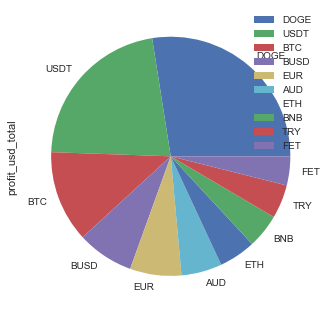

In [49]:
df_by_coin_top10.set_index("coin").plot.pie(y="profit_usd_total")

## Stable Coins Profit

In [50]:
STABLE_COIN_QUERY = "coin.str.contains(' BTC') or coin.str.contains('ETH') or coin.str.contains('EUR') or coin.str.contains('RUB') or coin.str.contains('USD')"

In [51]:
df_by_coin_stable = df_by_coin.query(STABLE_COIN_QUERY)

In [52]:
df_by_coin_stable = df_by_coin_stable.sort_values("profit_usd_total", ascending=False)
df_by_coin_stable

,coin,profit_total,profit_usd_total,roi,profit_avg,price_usd,profit_usd_avg,arbitrage_count
83,USDT,5096.575253,5096.575253,0.008908,8.609080,1.000000,8.609080,592
19,BUSD,1778.408335,1778.408335,0.008574,3.978542,1.000000,3.978542,447
34,EUR,1333.245801,1612.960771,0.010261,9.323397,1.209800,11.279446,143
33,ETH,0.323759,1153.859397,0.008305,0.000873,3563.950000,3.110133,371
68,RUB,14226.312371,191.757705,0.005079,169.360862,0.013479,2.282830,84
82,USDC,36.742205,36.742205,0.008214,3.674220,1.000000,3.674220,10
78,TUSD,3.096637,3.096637,0.003757,0.774159,1.000000,0.774159,4


In [53]:
stable_coints_total_profit = sum(df_by_coin_stable.profit_usd_total)
stable_coints_total_profit

9873.400301907692

<AxesSubplot:ylabel='profit_usd_total'>

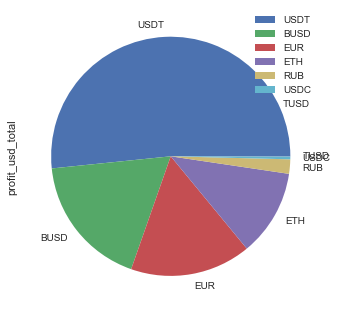

In [54]:
df_by_coin_stable.set_index("coin").plot.pie(y="profit_usd_total")

### Profit by second and thirds coins in the chain

In [211]:
topN = 20

In [212]:
# df_stable = df.query(STABLE_COIN_QUERY)
df_stable = df

In [213]:
df_stable_coin1 = df_stable.groupby("coin").sum()
top10_stable_by_coin1 = df_stable_coin1.sort_values("profit_usd", ascending=False)[:topN].reset_index()
top10_stable_by_coin1

,coin,roi,profit,price_usd,profit_usd
0,DOGE,4.354518,8855.698186,3.573085e+02,6379.467859
1,USDT,5.273372,5096.575253,5.920000e+02,5096.575253
2,BTC,4.196437,0.048768,2.833090e+07,2872.448410
3,BUSD,3.832363,1778.408335,4.470000e+02,1778.408335
4,EUR,1.467375,1333.245801,1.730014e+02,1612.960771
5,AUD,0.588567,1641.126708,6.439970e+01,1273.350212
6,ETH,3.081307,0.323759,1.322225e+06,1153.859397
7,BNB,1.566945,1.703000,8.329596e+04,1074.643977
8,TRY,1.263308,8754.012476,2.063224e+01,1056.227374
9,FET,0.401189,1593.331098,9.702920e+00,909.409658


In [214]:
df_stable_coin2 = df_stable.groupby("coin_2").sum()

In [215]:
top10_stable_by_coin2 = df_stable_coin2.sort_values("profit_usd", ascending=False)[:topN].reset_index()
top10_stable_by_coin2

,coin_2,roi,profit,price_usd,profit_usd
0,USDT,5.302737,15172.994420,6.531040e+06,6941.126955
1,BTC,5.779419,22247.610407,1.270441e+05,3676.367445
2,EUR,1.500979,3261.356400,1.239496e+06,2954.255579
3,BUSD,4.420715,4993.205061,1.928260e+06,2608.332620
4,TRY,2.127471,3502.969206,1.590607e+06,1545.710532
5,DOGE,1.540126,2908.405156,5.065533e+06,1308.189948
6,ETH,2.579236,1088.050018,2.651529e+06,1295.650395
7,BNB,1.817329,637.867026,7.977673e+05,1250.581375
8,AUD,0.499482,1386.647331,5.890590e+05,1066.473851
9,FET,0.229159,1.246381,6.457927e+04,786.773808


In [216]:
df_stable_coin3 = df_stable.groupby("coin_3").sum()

In [217]:
top10_stable_by_coin3 = df_stable_coin3.sort_values("profit_usd", ascending=False)[:topN].reset_index()
top10_stable_by_coin3

,coin_3,roi,profit,price_usd,profit_usd
0,DOGE,6.346498,23951.275216,4.300175e+06,7737.257876
1,USDT,3.529377,303211.682856,4.694469e+06,4600.345766
2,EUR,1.510579,3713.875353,1.415357e+06,3034.407127
3,BTC,3.823243,2639.555523,1.496788e+05,2440.488745
4,BUSD,3.414800,344245.097604,2.334453e+06,1268.305448
5,BNB,0.935308,1666.911004,4.770117e+03,1023.792245
6,ETH,2.287081,2863.967627,1.946273e+06,973.912429
7,FET,0.428265,22.203661,4.712100e+05,898.475054
8,TRY,1.654712,953.077382,2.642982e+05,897.988611
9,RVN,0.108375,3495.812936,1.184323e+05,817.488770


In [235]:
set_of_top_profit_coins = set(top10_stable_by_coin2.coin_2).intersection(set(top10_stable_by_coin3.coin_3))
#set_of_top_profit_coins = set(list(set_of_top_profit_coins) + list(top10_stable_by_coin1.coin))
set_of_top_profit_coins = set_of_top_profit_coins.intersection(top10_stable_by_coin1.coin)
len(set_of_top_profit_coins)

15

In [236]:
def filter_all_3_coins_in(_df, lst):
    _df_tmp = _df[_df.coin.isin(lst)]
    _df_tmp = _df_tmp[_df_tmp.coin_2.isin(lst)]
    _df_tmp = _df_tmp[_df_tmp.coin_3.isin(lst)]
    return _df_tmp

In [237]:
df_top_coins_only = filter_all_3_coins_in(df, set_of_top_profit_coins)
df_top_coins_only.head()

,roi,profit,market_path,market,coin_path,timems,end_market,coin,coin_2,coin_3,price_usd,profit_usd
38,0.003157,0.845447,ETH/USDT -> RLC/ETH -> RLC/USDT,ETH/USDT,USDT -> ETH -> RLC -> USDT,1620602662556,RLC/USDT,USDT,ETH,RLC,1.00,0.845447
39,0.003846,0.105428,ETH/USDT -> RLC/ETH -> RLC/USDT,ETH/USDT,USDT -> ETH -> RLC -> USDT,1620602662864,RLC/USDT,USDT,ETH,RLC,1.00,0.105428
40,0.003889,15.950707,ETH/USDT -> RLC/ETH -> RLC/USDT,ETH/USDT,USDT -> ETH -> RLC -> USDT,1620602663244,RLC/USDT,USDT,ETH,RLC,1.00,15.950707
41,0.005499,0.001096,ETH/USDT -> RLC/USDT -> RLC/ETH,ETH/USDT,ETH -> USDT -> RLC -> ETH,1620602696006,RLC/ETH,ETH,USDT,RLC,3563.95,3.904930
42,0.006799,0.000875,ETH/USDT -> RLC/USDT -> RLC/ETH,ETH/USDT,ETH -> USDT -> RLC -> ETH,1620602696329,RLC/ETH,ETH,USDT,RLC,3563.95,3.116840


In [238]:
df_top_coins_only_sum = sum(df_top_coins_only.profit_usd)
df_top_coins_only_sum

22084.553050971568

In [239]:
df_top_coins_only.groupby("coin").sum().sort_values("profit_usd", ascending=False)

,roi,profit,price_usd,profit_usd
coin,,,,
DOGE,3.381196,7898.555181,2.362846e+02,5689.961181
USDT,2.701638,4572.840489,3.260000e+02,4572.840489
BTC,2.073961,0.039051,1.496060e+07,2300.101699
EUR,0.834847,1290.322135,1.282388e+02,1561.031718
BUSD,1.300358,1442.603406,1.150000e+02,1442.603406
AUD,0.570213,1636.610175,6.052020e+01,1269.845834
TRY,1.216437,8697.186950,1.942568e+01,1049.371012
FET,0.401189,1593.331098,9.702920e+00,909.409658
ETH,0.808688,0.245904,4.098543e+05,876.388397


In [240]:
coin_parts = dict()
for coin in set_of_top_profit_coins:
    truncated_set = set_of_top_profit_coins.copy()
    truncated_set.remove(coin)
    df_top_coins_only = filter_all_3_coins_in(df, truncated_set)
    profit_usd_sum = df_top_coins_only_sum - sum(df_top_coins_only.profit_usd)
    coin_parts[coin] = profit_usd_sum

In [241]:
print("Coin participation influeces:\n")
sorted_coin_parts = sorted(coin_parts.items(), key=lambda x: x[1], reverse=True)
for el in sorted_coin_parts:
    print(el)

Coin participation influeces:

('USDT', 14974.750984865514)
('DOGE', 13726.783284629884)
('EUR', 7398.797007787169)
('BTC', 7271.367979905495)
('BUSD', 3779.201929151335)
('TRY', 3454.912392251783)
('ETH', 2718.577853193623)
('BNB', 2645.386260738189)
('FET', 2594.6585197710447)
('AUD', 2450.9742158944136)
('RVN', 2206.8329028807166)
('GXS', 1712.5486711988815)
('RLC', 649.771505230914)
('ONT', 379.07609340959243)
('STRAX', 290.0195520061825)


<AxesSubplot:title={'center':'Отсносительный вклад участия разных монет в цепочке арбитража'}>

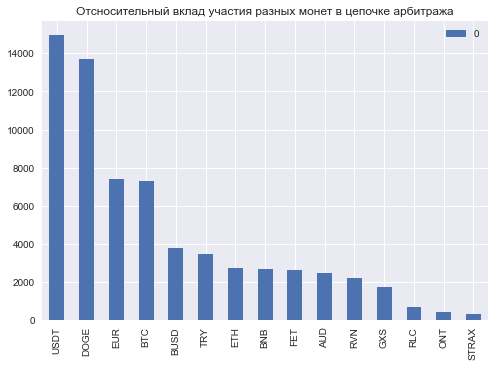

In [271]:
pd.DataFrame.from_dict(coin_parts, orient="index").sort_values(0, ascending=False).plot.bar(title="Отсносительный вклад участия разных монет в цепочке арбитража")


## Результаты

### Какие коины наиболее прибыльные, если стоят в начале цепочки

In [179]:
df_tmp = df_by_coin_top10.copy()
df_tmp.profit_usd_total = df_tmp.profit_usd_total.apply(lambda v: f"$ {round(v)}")
df_tmp.roi = df_tmp.roi.apply(lambda v: f"{round(100*v, 2)}%")
df_tmp.profit_usd_avg = df_tmp.profit_usd_avg.apply(lambda v: f"$ {round(v, 2)}")
df_tmp = df_tmp[["coin", "profit_usd_total", "roi", "profit_usd_avg", "arbitrage_count"]].rename(columns={
    "profit_usd_total": "Всего профит", "profit_usd_avg": "Средний профит на сделку", "arbitrage_count": "Кол-во арбтиражей"
})

df_tmp

,coin,Всего профит,roi,Средний профит на сделку,Кол-во арбтиражей
27,DOGE,$ 6379,0.88%,$ 12.86,496
83,USDT,$ 5097,0.89%,$ 8.61,592
18,BTC,$ 2872,0.87%,$ 5.97,481
19,BUSD,$ 1778,0.86%,$ 3.98,447
34,EUR,$ 1613,1.03%,$ 11.28,143
8,AUD,$ 1273,0.71%,$ 15.34,83
33,ETH,$ 1154,0.83%,$ 3.11,371
16,BNB,$ 1075,1.19%,$ 8.14,132
77,TRY,$ 1056,0.74%,$ 6.18,171
35,FET,$ 909,2.36%,$ 53.49,17


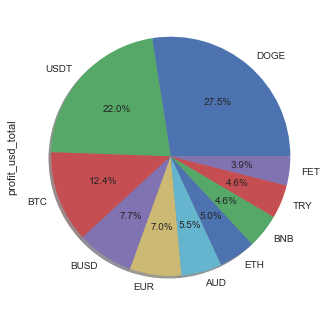

In [180]:
pie = df_by_coin_top10.set_index("coin").plot.pie(y="profit_usd_total", autopct='%1.1f%%', shadow=True, legend=False)

### Наиболее прибыльные монеты (если мы составляем арбитраж только из них)

In [275]:
top3_coins = [v[0] for v in sorted_coin_parts][:3]
top3_coins_profit = sum(filter_all_3_coins_in(df, top3_coins).profit_usd)
print(f"Наиболее прибыльная цепочка арбитража их трех монет в любой последовательности: \n {top3_coins} => всего $ {round(top3_coins_profit)}")

Наиболее прибыльная цепочка арбитража их трех монет в любой последовательности: 
 ['USDT', 'DOGE', 'EUR'] => всего $ 5801


In [282]:
net_profit_by_coins = dict()
net_profit_by_coins[str(top3_coins)] = top3_coins_profit

print("Как меняется прибыль, если мы добавляем по одной другие монеты, в порядке прибыльности\n")
for i in range(4, len(sorted_coin_parts)+1):
    extra_coin = sorted_coin_parts[i-1][0]
    topN_coins = [v[0] for v in sorted_coin_parts][:i]
    topN_coins_df = filter_all_3_coins_in(df, topN_coins)
    topN_coins_profit = sum(topN_coins_df.profit_usd)
    net_profit_by_coins[extra_coin] = topN_coins_profit
    print(f"+{extra_coin} => $ {int(topN_coins_profit)}")

Как меняется прибыль, если мы добавляем по одной другие монеты, в порядке прибыльности

+BTC => $ 6773
+BUSD => $ 9398
+TRY => $ 11275
+ETH => $ 11753
+BNB => $ 11800
+FET => $ 14395
+AUD => $ 16846
+RVN => $ 19053
+GXS => $ 20765
+RLC => $ 21415
+ONT => $ 21794
+STRAX => $ 22084


/Users/az/.pyenv/versions/3.7.7/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:title={'center':'График прибыли по цепочкам монет: начинаем с трех, добавляем по одной монете, и смотрим, как меняется прибыль (по данным выше)'}>

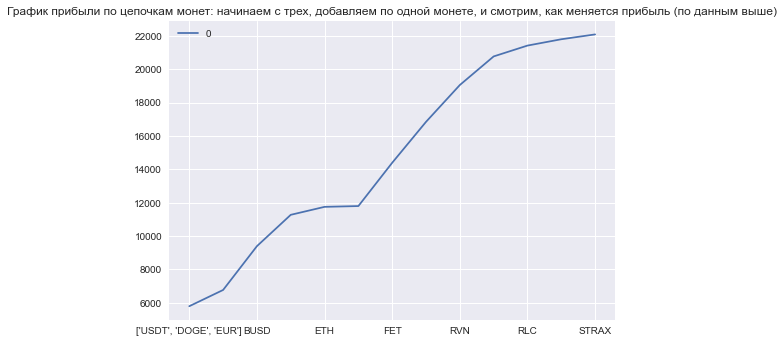

In [312]:
df_tmp = pd.DataFrame.from_dict(net_profit_by_coins, orient="index")
df_tmp.plot.line(
    title="График прибыли по цепочкам монет: начинаем с трех, добавляем по одной монете, и смотрим, как меняется прибыль (по данным выше)"
)

### Время жизни арбитража

По текущей статистике, соотношения ниже почти не меняются при выборке из самых прибыльных монет (вместо "всех монет").

Для стейблкоинов + BTC,ETH арбитражей крайне мало, и 100% уходят менее чем за 100 ms

In [318]:
print("Время жизни арбитражных сделок: ")
for k,v in arbitrage_ttls.items():
    if k == 0:
        print(f"Менее 0.1 сек: \t{v} ({round(100*v/total_grouped_arbitrage_counts, 2)}%)")
        continue
    print(f"Больше {round(k/1000,1)} сек: \t{v} ({round(100*v/total_grouped_arbitrage_counts, 2)}%)")

Время жизни арбитражных сделок: 
Менее 0.1 сек: 	2487 (85.11%)
Больше 0.1 сек: 	435 (14.89%)
Больше 0.2 сек: 	185 (6.33%)
Больше 0.3 сек: 	119 (4.07%)
Больше 0.4 сек: 	73 (2.5%)
Больше 0.5 сек: 	45 (1.54%)
Больше 0.6 сек: 	39 (1.33%)
Больше 0.7 сек: 	39 (1.33%)
Больше 0.8 сек: 	25 (0.86%)
Больше 0.9 сек: 	25 (0.86%)
Больше 1.0 сек: 	22 (0.75%)
Больше 1.1 сек: 	22 (0.75%)
Больше 1.2 сек: 	13 (0.44%)
Больше 1.3 сек: 	11 (0.38%)
Больше 1.4 сек: 	6 (0.21%)
Больше 1.5 сек: 	6 (0.21%)
Больше 1.6 сек: 	6 (0.21%)
Больше 1.7 сек: 	6 (0.21%)
Больше 1.8 сек: 	3 (0.1%)
Больше 1.9 сек: 	3 (0.1%)
Больше 2.0 сек: 	3 (0.1%)
Больше 2.1 сек: 	2 (0.07%)
Больше 2.2 сек: 	0 (0.0%)
Больше 2.3 сек: 	0 (0.0%)
Больше 2.4 сек: 	0 (0.0%)


<AxesSubplot:title={'center':'Количество сделок, живущих дольше чем Х милисекунд (1000 милисекунда = 1 секунда)'}>

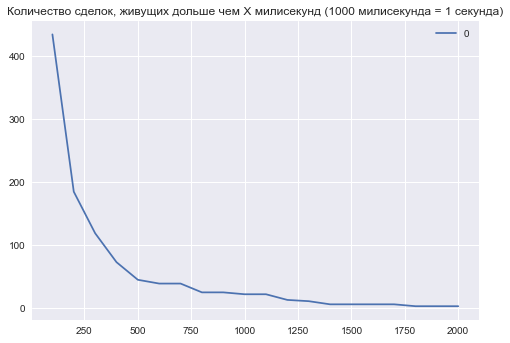

In [319]:
df_tmp = pd.DataFrame.from_dict(ttls, orient="index")
df_tmp.plot.line(title="Количество сделок, живущих дольше чем Х милисекунд (1000 милисекунда = 1 секунда)")

### Еще немного статистики

In [289]:
print(f"""
    Total {len(df.coin.unique())} coins, potential profit: \t$ {round(all_coins_total_profit)}
    Start with stable [*USD, BTC, ETH]:\t$ {round(stable_coints_total_profit)}
    Start with Best Coin '{df_by_coin_top10.iloc[0].coin}': \t$ {round(df_by_coin_top10.iloc[0].profit_usd_total)}
    Start with Best Stable '{df_by_coin_stable.iloc[0].coin}': \t$ {round(df_by_coin_stable.iloc[0].profit_usd_total)}
    If only {top3_coins}:\t$ {round(top3_coins_profit)}
    If OLNY top{len(sorted_coin_parts)} coins: \t\t$ {round(df_top_coins_only_sum)}
    ----------------
    First Arbitrage Found Time: \t{starttime}
    Last Arbitrage Found Time: \t\t{endtime}
""")


    Total 91 coins, potential profit: 	$ 26735
    Start with stable [*USD, BTC, ETH]:	$ 9873
    Start with Best Coin 'DOGE': 	$ 6379
    Start with Best Stable 'USDT': 	$ 5097
    If only ['USDT', 'DOGE', 'EUR']:	$ 5801
    If OLNY top15 coins: 		$ 22085
    ----------------
    First Arbitrage Found Time: 	2021-05-08 17:22:35.320000
    Last Arbitrage Found Time: 		2021-05-12 16:39:10.708000

